# Predicting vertical streambed discharge from temperature measurements and differential pressure

We will use `ginette` to predict streambed discharge from temperature measurements in real time. In particular, the class `tempest1d.EKF` provides an extended Kalman filter. Here's an example.

You can find the `ginette` repository on GitHub: [ginette GitHub Repository](https://github.com/agnes-riviere/ginette)

Ginette models temperature by solving a two-dimensional, unsaturated and fully saturated form of the hydrologic energy transport equation [1]. In three dimensions, the equation is

$\frac{d}{dt} \left( \left[\phi {C}_w + \left( 1-\phi \right) {C}_{sed} \right] T \right) = \nabla \cdot \left( \lambda \nabla T \right) - \nabla \cdot \left( \phi {C}_w \vec{v} T \right)$,

where 
$t$ is time in s,
$\phi$ is porosity (a unitless fraction of total volume),
${C}_w$ is the volumetric specific heat capacity of water in J/m$^3$&deg;C,
${C}_{sed}$ is the volumetric specific heat capacity of the dry sediments in J/m$^3$&deg;C,
$T$ is temperature in &deg;C,
$\lambda$ is the thermal conductivity of the porous media in W/m&deg;C (4 models are available to take account ice, water, solid and air),
and $\vec{v}$ is the water velocity in m/s.


## Mass Balance Equation for Pore-Water Pressure

The mass balance equation used to calculate the pore-water pressure in the ($x$,$z$) plane is written:

$\frac{\partial}{\partial{x}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{x}}\right)\right) + \frac{\partial}{\partial{z}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{z}}+\rho_w g\right)\right) = \frac{S_{k}}{g} \frac{\partial{p}}{\partial{t}}  $

where 
- $t$ is time (s),
- $p$ is the pressure (Pa),
- $k$ is the intrinsic permeability ($m^{2}$),
- $k_{r}$(T,Sat) is the relative permeability,
- $g$ is the acceleration due to gravity (m\,$s^{-2}$),
- $\mu$ is the dynamic viscosity of water (Pa\,s),
- $\rho_{w}$ is the density of water (kg\,$m^{-3}$),
- $S_{k}$ is the specific storage coefficient ($m^{-1}$, see below).

The specific storage coefficient for fully saturated cells  is the specific storage coefficient $S_{s}$ in case of confined aquifer.

$S_{k}=S_{s}= \rho_{w} \, g \, n \, \left(\beta_f-\beta_s + \frac{\alpha_{c}}{ n }\right)$ , 

where 
- $n$ is the total porosity,
- $\beta_f$ is the compressibility of water ($Pa^{-1}$),
- $\beta_s$ is the compressibility of the solid rock grains ($Pa^{-1}$),
- $\alpha_c$ is the compressibility coefficient of the porous medium ($Pa^{-1}$).

For the unconfined aquifer, the specific storage coefficient is written:

\[
S_{k}=\frac{n_{d}}{e \, s_{w}},
\]

with 
- $n_{d}$ the drainable porosity,
- $e$ the thickness of the grid cell (m),
- $s_{w}$ the saturation of  water.
  
The Richards equation is also implemented but we won"t use it.




In [88]:
import sys
import os

# Ajoutez le chemin au sys.path
sys.path.append('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python')



# Listez les fichiers dans le répertoire pour vérifier que Init_folders.py est présent
print("\nFichiers dans le répertoire src_python :")
print(os.listdir('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/'))

# Importez les modules
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import array

from Init_folders import prepare_ginette_directories, compile_ginette
import Direct_model
from Read_obs import process_obs_data
import Plot
import importlib
importlib.reload(Direct_model)
importlib.reload(Plot)
from Direct_model import setup_ginette, generate_zone_parameters, initial_conditions, boundary_conditions, run_direct_model, remove_first_two_days
from Plot import plot_obs, plot_obs_zoom, plot_compare_temperatures_obs_sim, plot_temperatures_profiles, plot_water_profiles_interpol, plot_temperature_profiles_interpol, plot_heat_flux_profiles_interpol,plot_fluxes_timeseries

# Dossiers
Obs_data = '../OBS_point/Point1Touques/'
prepare_ginette_directories('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/GINETTE_SENSI/')


Fichiers dans le répertoire src_python :
['Plot.py', 'Read_obs.py', 'stat_critere.py', '__pycache__', 'Direct_model.py', 'Init_folders.py']
Current working directory: /home/ariviere/Programmes/ginette/application/2024_TD_ENS/GINETTE_SENSI
Directory 'SENSI' already exists.
Directory 'OUTPUT' already exists.


# 1. Read observation data

In [76]:
date_simul_bg=pd.to_datetime("2022/04/21 14:00:00")
## 0 steady state
# 1 transient state (dynamic state)
state=1
coef=0.01
ost=0
nb_day=30
obs_temp = process_obs_data(Obs_data, date_simul_bg, coef, ost, nb_day)

['deltaP_Point1Touques_14_04_22.csv', 'Temp_Point1Touques_14_04_22.csv']
2022-04-21 14:15:00 2022-05-21 14:15:00
Toutes les différences entre les lignes sont de 900 secondes.


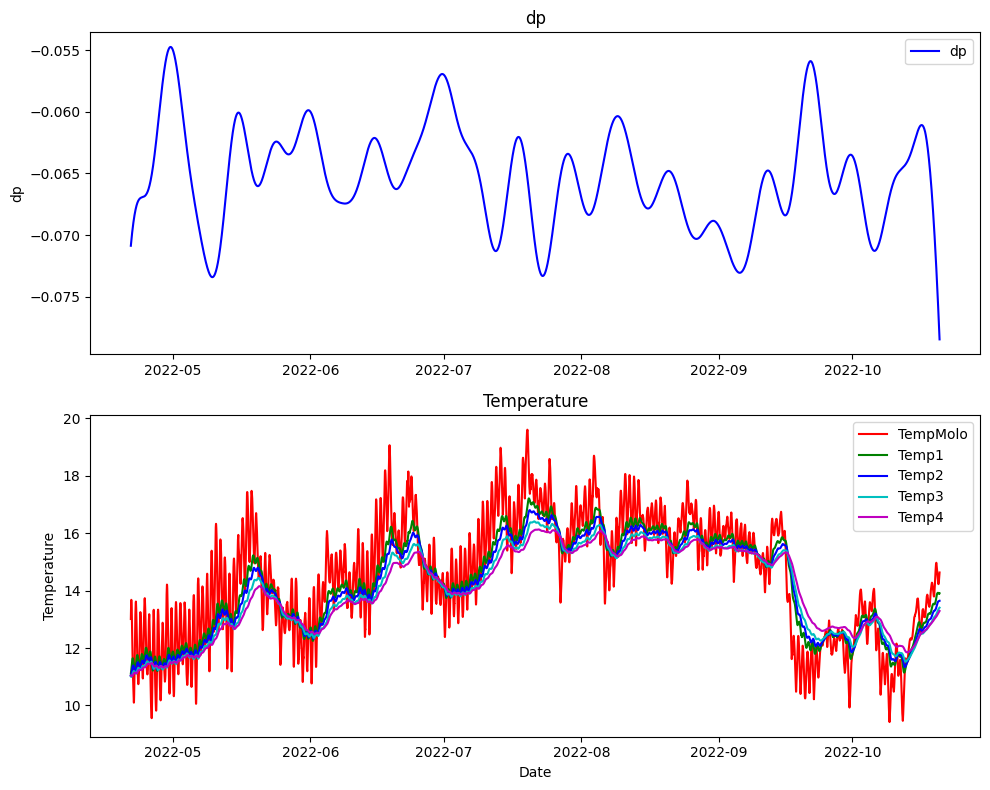

In [77]:
plot_obs(obs_temp)

## Zoom plot



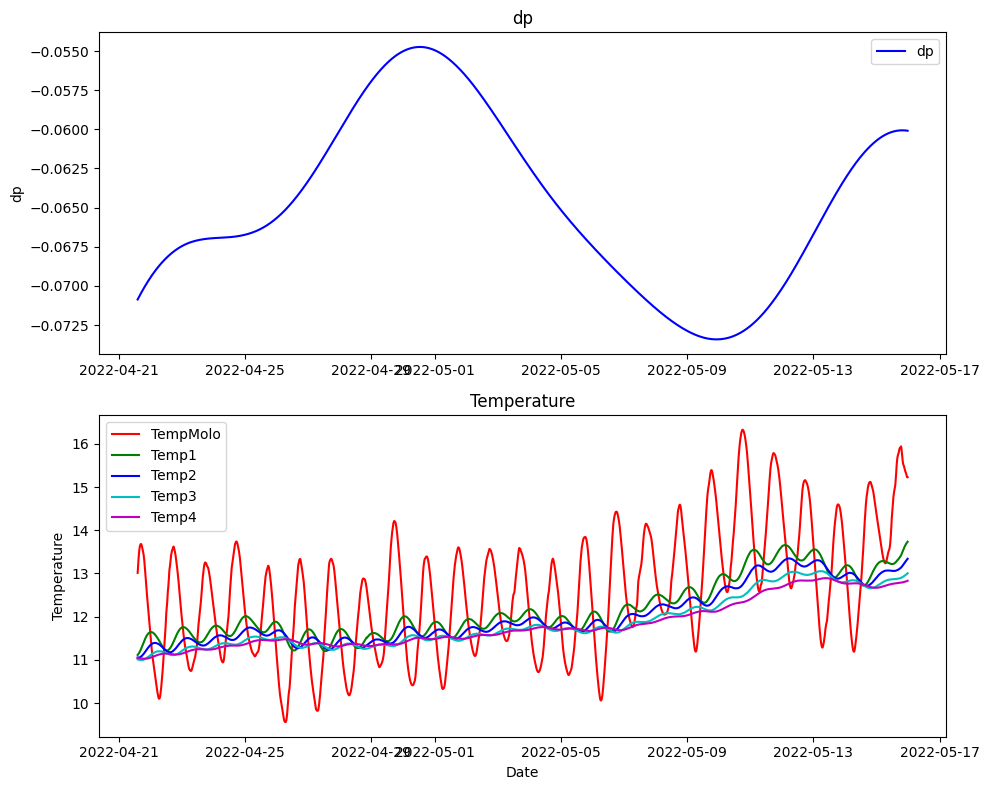

In [78]:
start_date = '2022-04-21'
end_date = '2022-05-16'

plot_obs_zoom(obs_temp, start_date, end_date)


# 1. riverbed parameters

Thanks to this script we will carry out an inversion of the parameters of the riverbed, t
The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the intinsic permeability k,
- the thermal condictivity, 
- the heat capacity, 



# 1.1 Initiation Ginnette files

In [86]:
compile_ginette()


########### Setup of the model

#time step in s
dt=900

# size columnin meter
z_top=0.0
z_bottom=-0.4
az=abs(z_top-z_bottom)
#discretisation : size cell in meter
dz=0.01
dz_obs=0.1
coef = 0.01
ost = 0
nb_day = 30


z_obs=setup_ginette(dt, state, nb_day, z_top, z_bottom, az, dz, date_simul_bg,dz_obs)



ginette does not exist
You must compile ginette in the current directory
Command: gfortran -o ginette ../../src/ginette_V2.f
la simulation commence à 2022-04-21 14:00:00


f951: Warning: Nonexistent include directory ‘../../src’ [-Wmissing-include-dirs]
f951: Error: Cannot open file ‘../../src/ginette_V2.f’
<built-in>: Fatal Error: cannot open input file: ../../src/ginette_V2.f
compilation terminated.


In [55]:
# Nombre de faciès dans la colonne. Si nb_zone=1, le milieu poreux est homogène.
nb_zone = 1

# Altitude de la limite en mètres. Si vous voulez plus de couches, ajoutez une nouvelle ligne.
alt_thk = -0.11


# Porosité
REF_n = 0.8  # \omega

#-----------------------------------------------------------------
## Perméabilité intrinsèque [m2]  k=K*mu/(rho*g)
## K Conductivité hydraulique [m.s-1]
## Paramètres constants
### mu Viscosité [Pa.s]
### rho Densité [kg.m-3]
### g Gravité  9.81 [m2.s-1]

# k=10**REF_k
REF_k = -13.5

# Conductivité thermique [W.m-1.K-1]
REF_l = 2

# Calcul de la capacité thermique dans Ginette par la relation suivante :
#  c_pm = c_w * r_w * n * sat + c_s * r * (1-n) + c_a * r_a * n * (1-sat)
# rho_m imposé : 1000
# c_s Capacité thermique spécifique du solide
# val_c = c_s m2/s2/C. Il est conseillé de laisser cette valeur constante.
# Il n'est pas possible de calibrer les deux paramètres rho et c en même temps.
# c_w = 4185D+00 m2/s2/C
# r_w = 1000 kg/m3
# Densité du solide r = val_r
# REF_c = 1000 valeur fixe
# Densité des grains solides rho_s = val_r [kg.m-3]
REF_r = 3500

# Si nb_zone == 2, définir les paramètres pour la deuxième zone
if nb_zone == 2:
    REF_n2 = 0.3  # \omega
    REF_k2 = -13  # K=10**REF_k
    REF_l2 = 2.65  # Conductivité thermique [W.m-1.K-1]
    REF_r2 = 3500  # Densité des grains solides rho_s = val_r [kg.m-3]








## 2. Initial and boundary conditions 

In [56]:
initial_conditions(obs_temp, z_top, z_bottom, dz, z_obs)
boundary_conditions(obs_temp)


# 3. Constant parameters

In [57]:
REF_k = 10**REF_k
REF_l = REF_l
REF_n = REF_n
REF_r = REF_r
if nb_zone==2:
    REF_k2 = 10**REF_k2
    REF_l2 = REF_l2
    REF_n2 = REF_n2
    REF_r2 = REF_r2
if nb_zone==1:
    sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 
if nb_zone==2:
    sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, REF_r, REF_k2=REF_k2, REF_n2=REF_n2, REF_l2=REF_l2, REF_r2=REF_r2)
    


# 4 warmup period 2 days

In [58]:
sim_temp,obs_temp=remove_first_two_days(sim_temp,obs_temp)



# 5. Comparaison Obs Sim

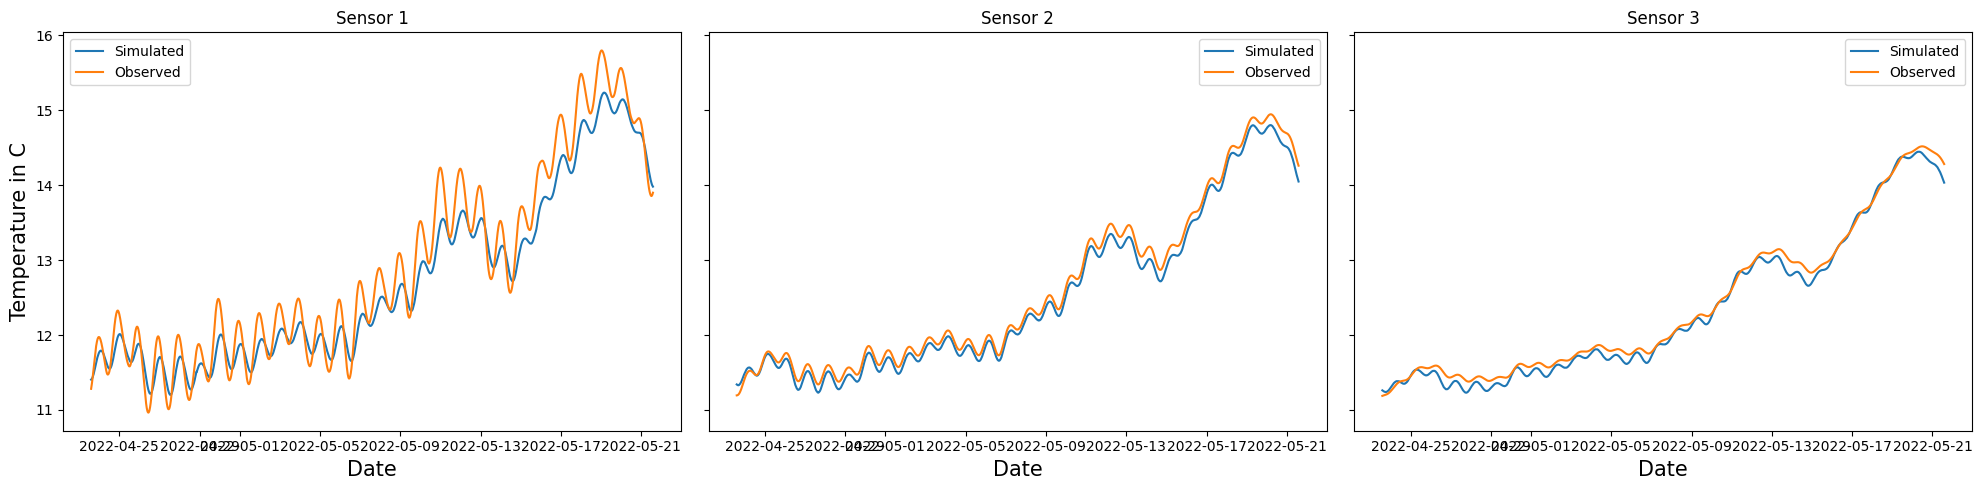

In [59]:
plot_compare_temperatures_obs_sim(obs_temp, sim_temp)

# 6. plot temperature profiles

/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/Plot.py:140: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


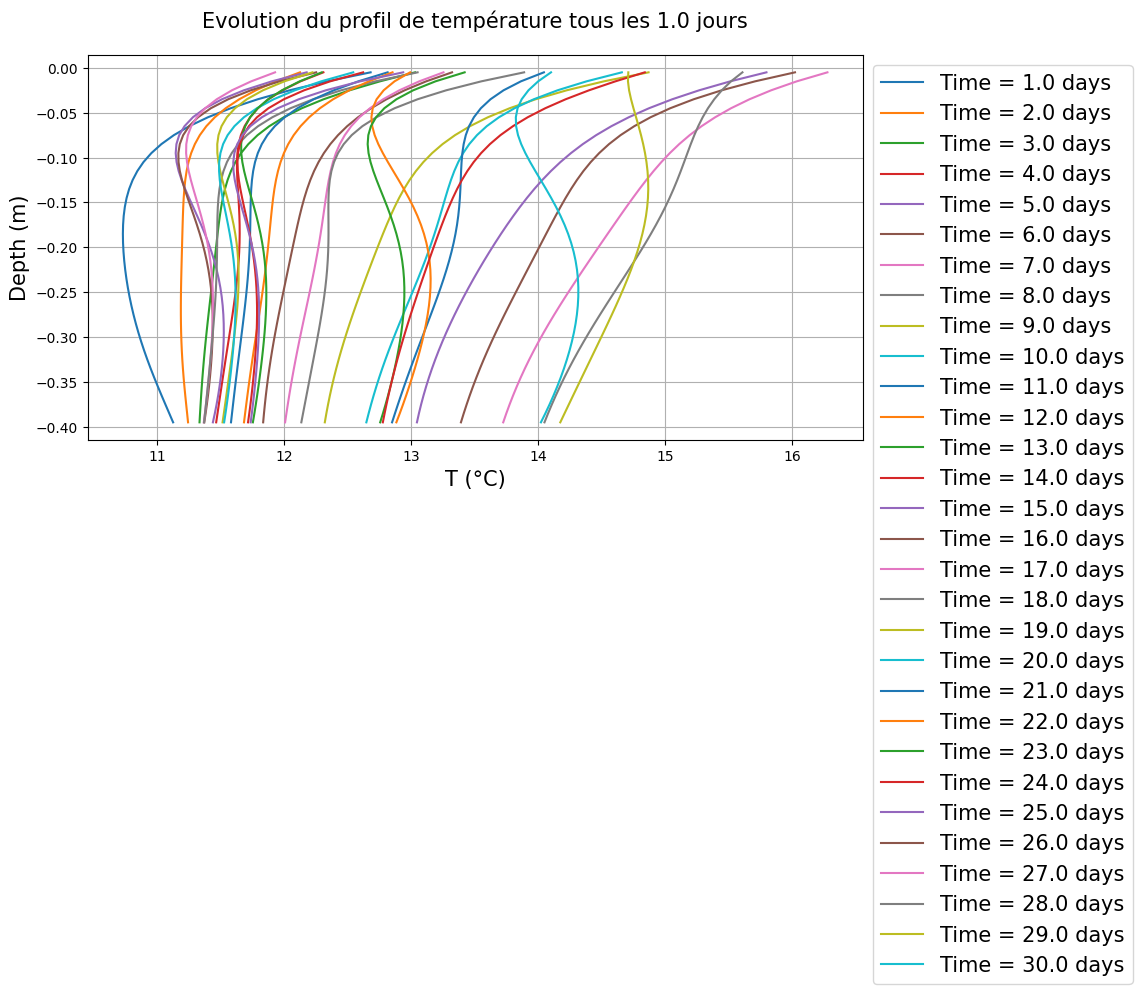

In [60]:
plot_temperatures_profiles(interval=86400)

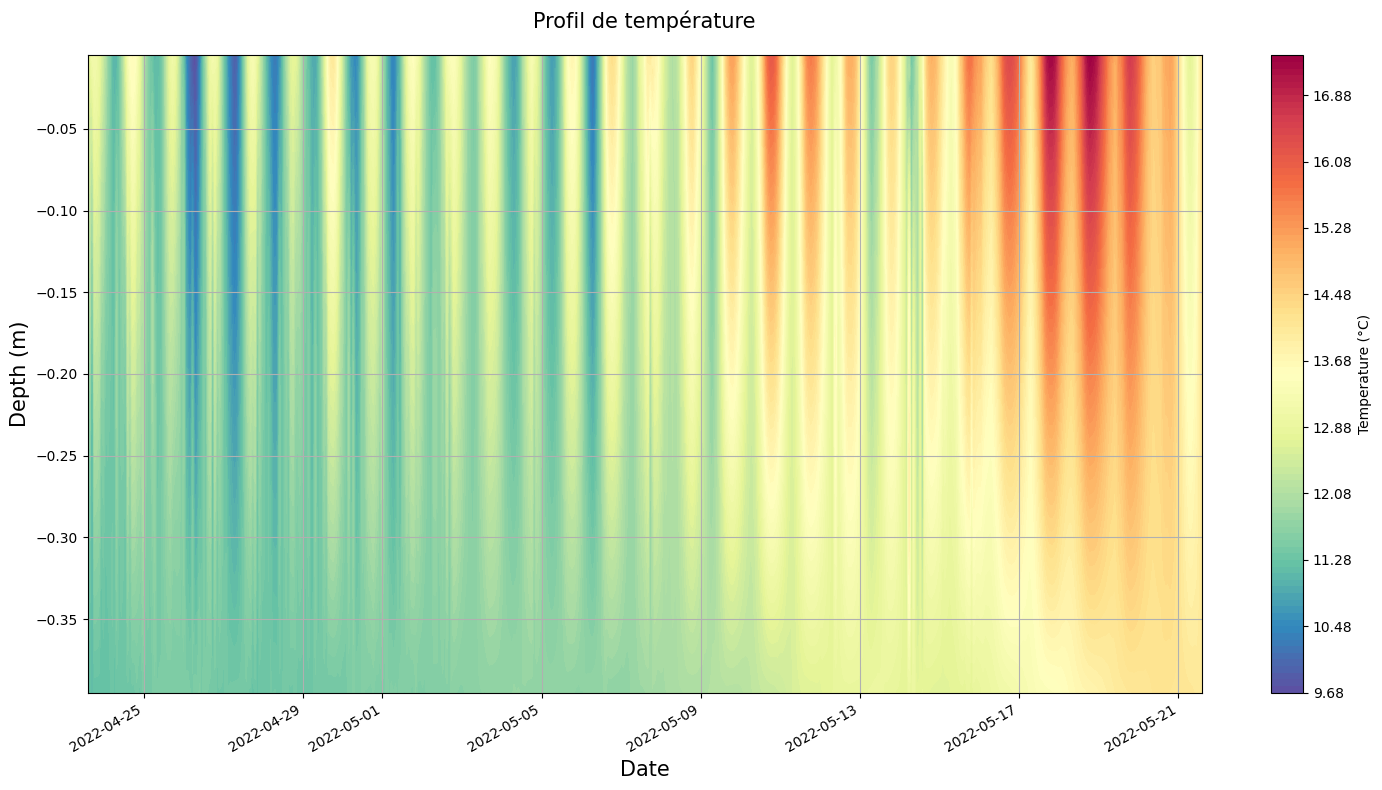

In [28]:
plot_temperature_profiles_interpol(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

# 7. plot the water stream-aquifer exchanges

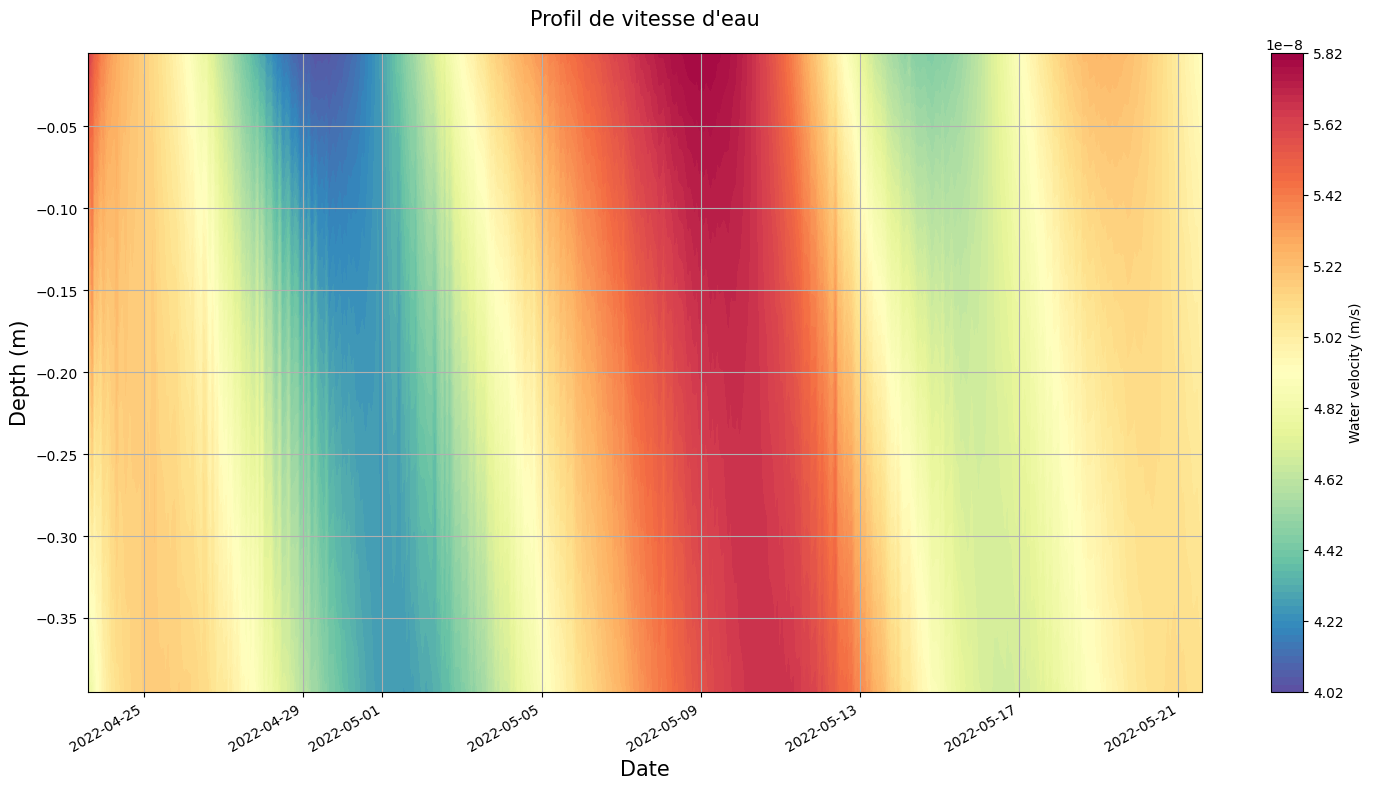

In [29]:
plot_water_profiles_interpol(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

# 8. plot the heat stream-aquifer exchanges

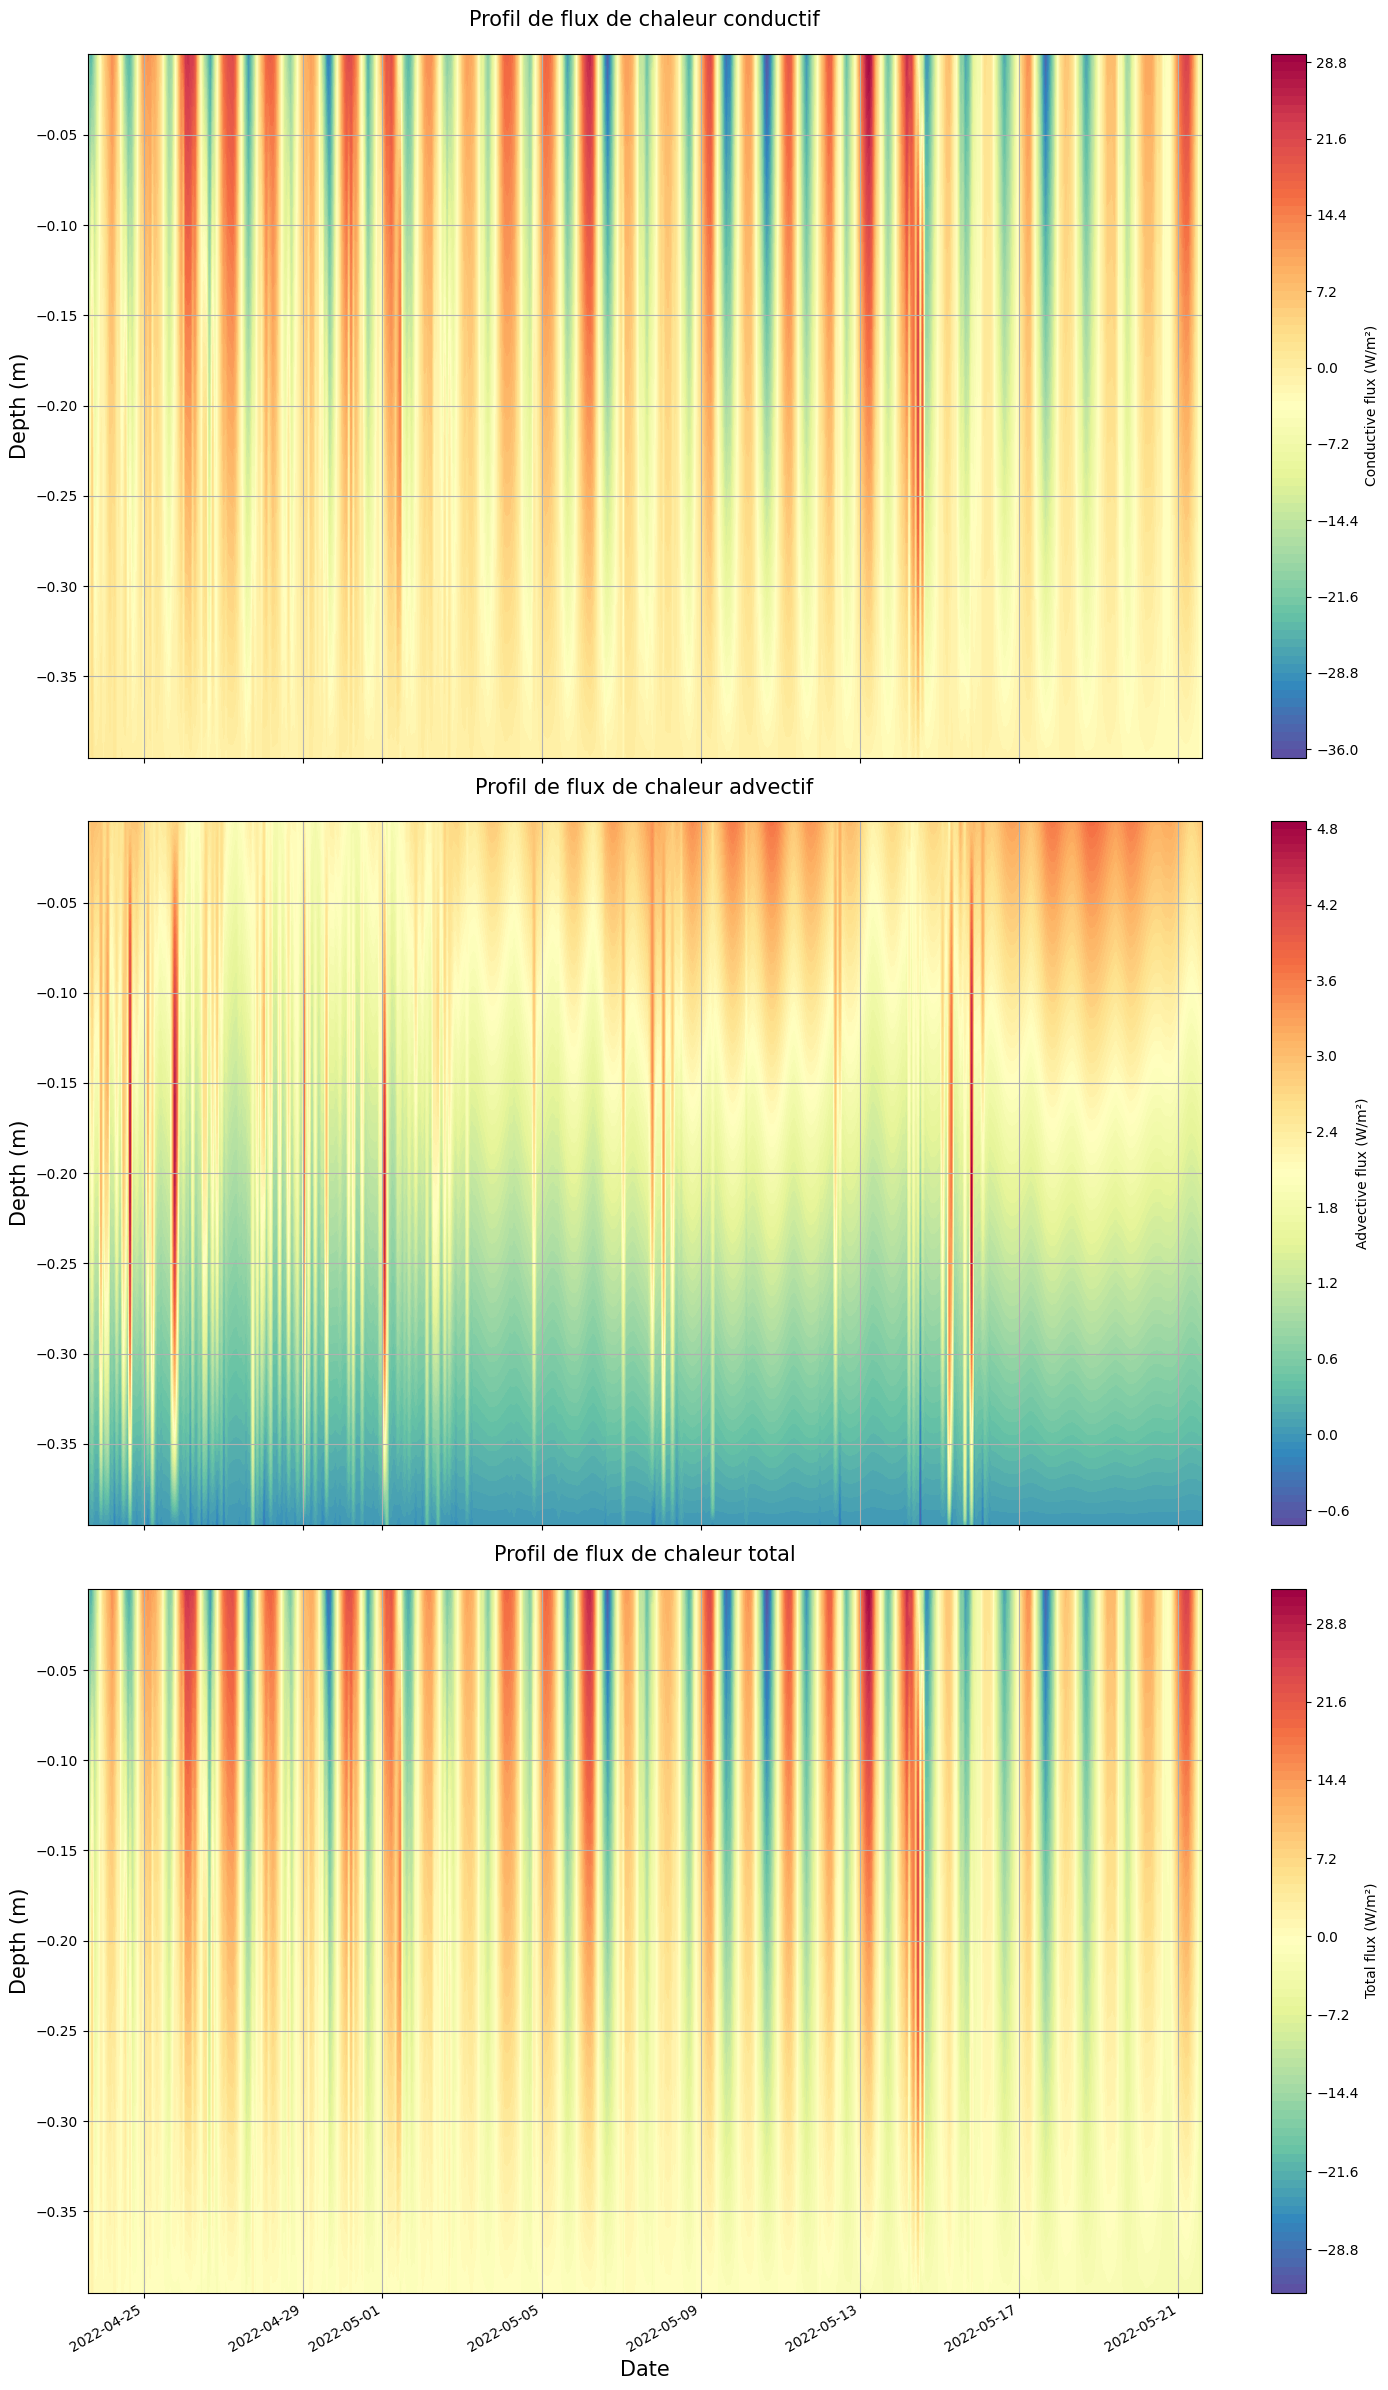

In [30]:
plot_heat_flux_profiles_interpol(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

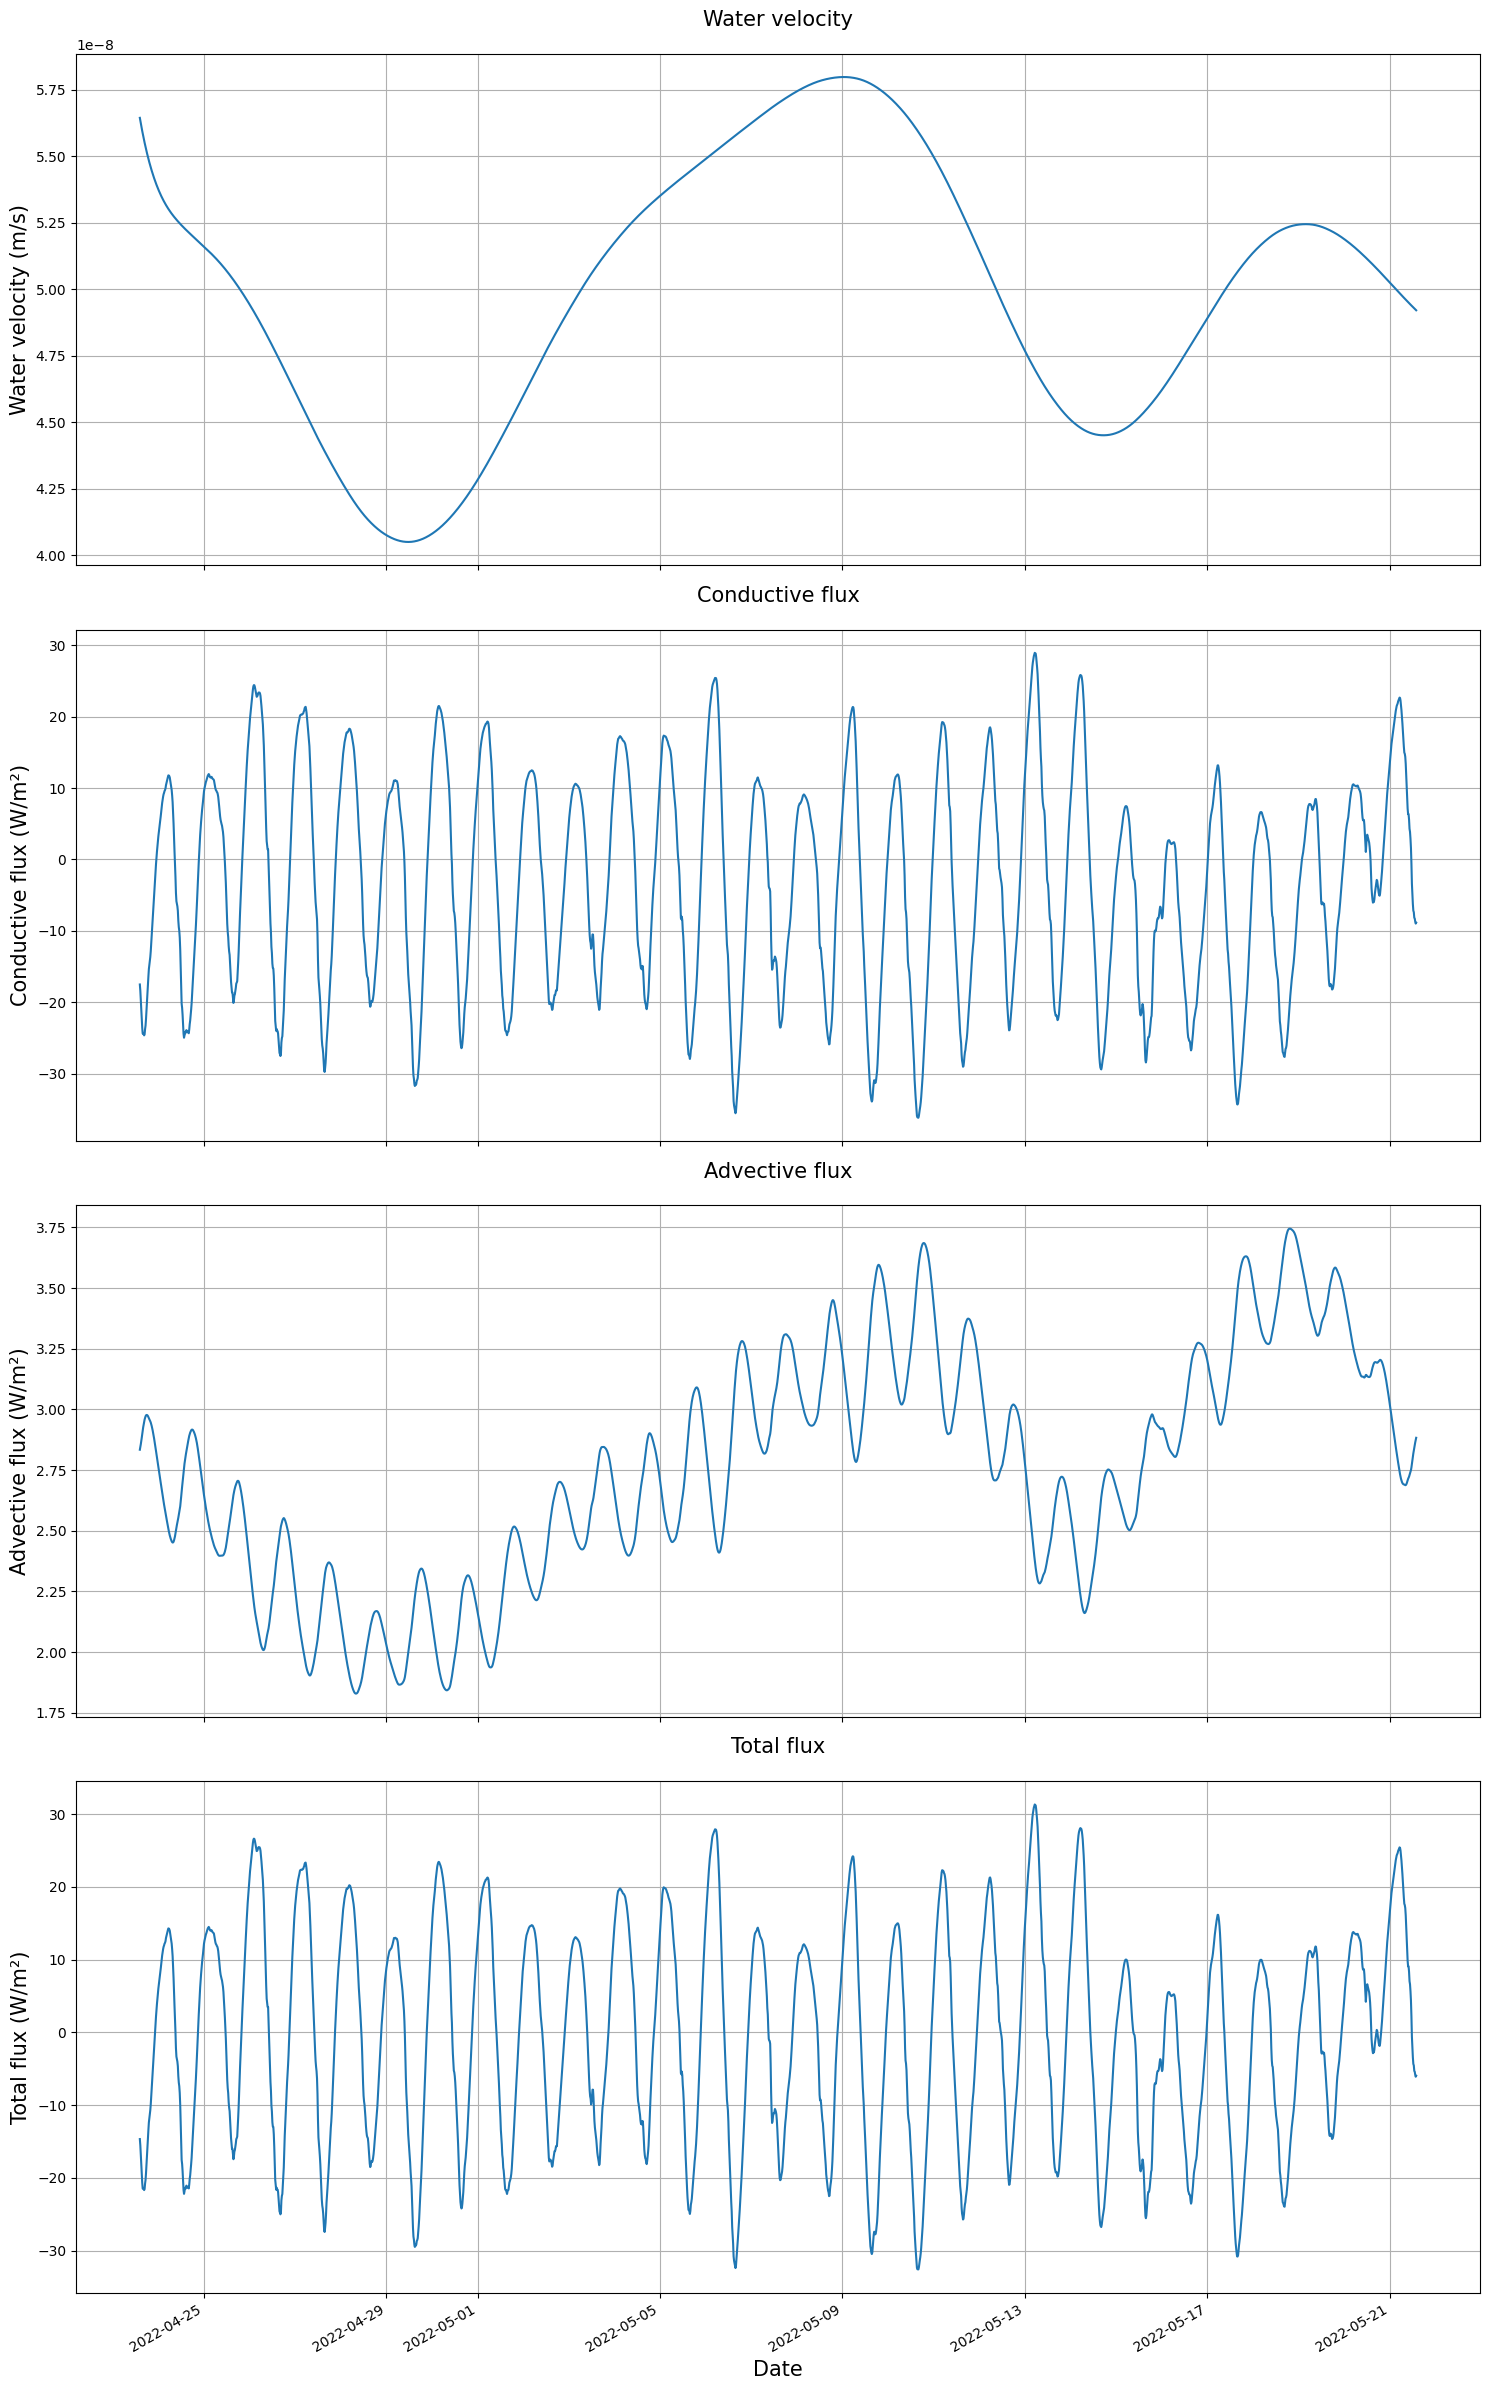

In [89]:
plot_fluxes_timeseries(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))